***
# CIÊNCIA DE DADOS EM SEGURÂNÇA
***

Desenvolvido pelas alunas **Eduarda Moresco**, Discente de Informática Biomédica na Universidade Federal do Paraná, **UFPR**, Curitiba, Brasil; e **Fernanda Kawasaki**, Discente de Ciências da Computação na Universidade Federal do Paraná, **UFPR**, Curitiba, Brasil.

Relatório para a aula de Ciência de Dados em Segurança, ministrada pelo professor **André Grégio** da Universidade Federal do Paraná, **UFPR**, no primeiro semestre de 2021; visando a aplicação de técnicas de ciência de dados em um dataset de escolha dos alunos.

# 1 INTRODUÇÃO AO PROBLEMA
***

Um software malicioso, ou ***malware***, é um termo mais amplo que descreve qualquer programa ou código malicioso que execute atividades arbitrárias em nome de um invasor, ou que aja de uma forma (automatizada ou não) que ameace os aspectos de segurança do sistema comprometido, seus usuários e dados associados. Ou seja, interferindo no funcionamento normal de computadores, sistemas de computador, redes, tablets e dispositivos móveis.

A proliferação de *malware* representa uma grande ameaça à tecnologia da informação moderna. De acordo com um relatório recente da Microsoft,***a cada três varreduras de malware resulta em uma detecção positiva***. Apesar de toda a evolução na detecção de softwares maliciosos, observa-se a falta de uma taxonomia padrão de uso geral. 



## 1.1 Justificativa
***

Cada antivirus tem sua rotulação realizada por engines. De forma geral, elas identificam os *malwares* com base em um banco de dados próprio e, com o resultado em mãos, atribuem um rótulo utilizando um padrão definido. Como cada engine possui padrão único de nomear os *malwares* encontrados, temos diversos rótulos para um mesmo hash (*MD5*, *SHA1*, *SHA256*). Nota-se, também, que a diferença vai além da nomenclatura, pois a interpretação de cada engine tem sua variação, fazendo com que um malware possa ser considerado *Trojan* por um antivírus e *Worm* por outro.


## 1.2 Objetivo
***

O vigente trabalho tem como objetivo o estudo sobre a rotulação e suas relações, mais especificamente, se é possivel, utilizando rótulos diversos para um mesmo malware, classificar em duas classes genéricas.
Visando no futuro, analisar a possibilidade de se construir uma árvore ou um grafo de rótulos gerados por entidades distintas que no final, pode-se aplicar uma redução e normalização para uma label "padrão".

#2 Dataset
***

Instalando recursos necessários para a leitura dos arquivos



In [ ]:
!pip install jsonlines
!pip install plotly --upgrade

     |████████████████████████████████| 13.2MB 254kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


Conectando com o diretório que contém os arquivos no GoogleDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g57KgL8c4OIEQSrQmZtgcmW7FxXHdjFurDdOPiI2FMAh8I6FpzSh0U
Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/DSS

/content/drive/MyDrive/DSS


Dados brutos
***

Os dados utilizados para criar o *dataset* de análise foram compostos por um conjunto de arquivos com resultados de detecção de *malware* por um grupo de antivírus disponibilizados pela plataforma **VirusTotal**.
Constituídos majoritariamente por **atributos textuais** possui em torno de **20.000 exemplares.**

##2.1 Carregando os dados
***

In [ ]:
import os
import jsonlines
import pandas as pd

In [ ]:
objects = []

for filename in os.listdir('Jsons/'):
    with jsonlines.open('Jsons/' + filename) as reader:
        for obj in reader:
            if "md5" in obj:
                d = {key: value for key, value in obj.items() if key in ['scans', 'md5', 'positives', 'scan_id', 'sha1', 'sha256', 'total']}
                objects.append(d)

In [ ]:
df = pd.DataFrame(objects)

##2.2 Análise da distribuição dos dados
***

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

###a. Representação visual da porcentagem de identificação de *malware* total dos antivírus

In [ ]:
pos = 100*df['positives'].sum()/df['total'].sum()
neg = 100-pos

In [ ]:
total_detection_fig = px.pie(names=['Identificado', 'Não identificado'], values=[pos, neg], title='Taxa de detecção de malware', color_discrete_sequence=['#150578', '#E1E2DF'])
total_detection_fig.update_layout(showlegend=False, font_size=16, title={'x':0.5, 'xanchor': 'center', 'yanchor': 'top'})
total_detection_fig.update_traces(textposition='inside', textinfo='percent+label')

###b. Gráfico de barras entre positivos e negativos por antivírus

In [ ]:
def countDetection(scan, avs):
    if scan:
        for key in scan.keys():
            try:
                if scan[key]['detected']:
                    avs[key]['positives'] += 1
                else:
                    avs[key]['negatives'] += 1
            except:
                avs[key] = {'positives': 0, 'negatives': 0}

In [ ]:
avs = {}
_ = df['scans'].map(lambda scan: countDetection(scan, avs))

In [ ]:
#criando dataset com as informações de detecção por antivírus
avs_df = pd.DataFrame(avs).transpose() #Reflect the DataFrame over its main diagonal by writing rows as columns and vice-versa. 
avs_df['total'] = avs_df['positives'] + avs_df['negatives']
avs_df['percentage'] = avs_df['positives']/avs_df['total']
avs_df = avs_df.sort_values(by='positives', ascending=False)

In [ ]:
avs_df

,positives,negatives,total,percentage
McAfee,21468,857,22325,0.961613
AVG,21452,826,22278,0.962923
McAfee-GW-Edition,21374,750,22124,0.966100
Symantec,21367,793,22160,0.964215
Kaspersky,21127,1181,22308,0.947059
...,...,...,...,...
Trustlook,3,396,399,0.007519
PCTools,3,23,26,0.115385
eSafe,2,16,18,0.111111
Avast-Mobile,0,6736,6736,0.000000


In [ ]:
antivirus_detection_fig = go.Figure(data=[
    go.Bar(name='Identificado', x=avs_df.index, y=avs_df['positives'], marker_color='#47C281', width=0.8),
    go.Bar(name='Não identificado', x=avs_df.index, y=avs_df['negatives'], marker_color='#E77474',  width=0.8)
])

antivirus_detection_fig.update_layout(title='Distribuição da detecção por antivírus', barmode='stack', paper_bgcolor='#ffffff', plot_bgcolor='#ffffff', width=2000, font={'color': 'gray'})

##2.3 Formatação dos dados
***

###a. Limpeza dos dados

Foram considerados os 10 antivírus cujo número de ameaças identificadas foi maior que nos outros, tendo em vista a necessidade de vários rótulos para os processos de Machine Learning.


In [ ]:
from collections import Counter
import numpy as np

In [ ]:
# pegando os 10 maiores antivírus
selected_avs = avs_df[:10].index

In [ ]:
def get_labels_per_md5(row, hashes):
    md5 = row['md5']
    if md5 not in hashes: # Checa se existe a chave do md5
        hashes[md5] = {}

    if row['scans']:
        for av in row['scans']:
            if row['scans'][av]['result']:
                hashes[md5][av] = row['scans'][av]['result']
            else:
                hashes[md5][av] = False

In [ ]:
hashes = {} # Dicionário com md5 (key) e os antivírus que o analisaram (values)

_ = df.apply(lambda row: get_labels_per_md5(row, hashes), axis=1)
labels = pd.DataFrame(hashes).transpose()
labels = labels[selected_avs]

In [ ]:
words = []
_ = labels.applymap(lambda label: words.append(label))

###b. Agrupando os dados

As **linhas que estavam sem informação foram removidas**, as que permaneceram foram classificadas em duas categorias seguindo a seguinte regra : se sete ou mais antivirus para aquele mesmo malware o classificaram como trojan então sua label recebia **Trojan,** caso contrário , se três ou menos recebia **Sem Trojan**. 

In [ ]:
labels.replace(r'', np.nan, inplace=True)
labels.replace(False, np.nan, inplace=True)
notna_labels = labels.dropna()

In [ ]:
def get_class(row):
    terms = []
    for label in row:
        terms.append(label)
    count = Counter(terms)

    trojans = 0
    for key in count:
        if 'Trojan' in key:
            trojans += count[key]

    if trojans<=3:
        return 'Sem trojan'
    elif trojans>=7:
        return 'Trojan'
    else:
        return False

In [ ]:
notna_labels['target'] = notna_labels.apply(get_class, axis=1)
notna_labels = notna_labels[notna_labels['target']!=False]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



E então balanceamos o dataset deixando em torno de 500 instâncias por classificação.

In [ ]:
not_troj = notna_labels.groupby('target').get_group('Sem trojan').sample(500)
troj = notna_labels.groupby('target').get_group('Trojan').sample(500)
balanced_labels = pd.concat([troj, not_troj])

In [ ]:
Ntrojan_value = balanced_labels['target'].value_counts()[0]
trojan_value = balanced_labels['target'].value_counts()[1]
total = Ntrojan_value  + trojan_value 

In [ ]:
pos = 100*Ntrojan_value /total
neg = 100-pos

balanced_fig = px.pie(names=['Sem Trojan', 'Trojan'], values=[pos, neg], title='Taxa de distribuição de malware', color_discrete_sequence=['#150578', '#E1E2DF'])
balanced_fig.update_layout(showlegend=False, font_size=16, title={'x':0.5, 'xanchor': 'center', 'yanchor': 'top'})
balanced_fig.update_traces(textposition='inside', textinfo='percent+label')

###c. TF-IDF : Extraindo características

Por último o algoritmo **TF-IDF** (*term-frequency X inverse document frequency*) foi utilizado para **transformar as labels que eram atributos textuais em atributos numéricos.** 

Em outras palavras,o *TF-IDF* é um cálculo estatístico que mede quais **termos**  são mais **relevantes dentro de um escopo textual**, analisando a frequência com que aparecem em uma sentença, em comparação à sua frequência em um conjunto maior de informações.

Dessa forma, passamos todas as labels para a construção do vetor de característica, muito parecido a um **dicionário** onde a chave é o termo e o valor o resultado do cálculo realizado pelo *TF-IDF* para o mesmo, e **o utilizamos para conceder o valor a cada rótulo**.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# transformando labels em um texto só
words = []
_ = balanced_labels[selected_avs].applymap(lambda label: words.append(label))

In [ ]:
# Calcula o TF-IDF
vect = TfidfVectorizer(token_pattern=r'[\d\D]*', lowercase=False) # token_pattern='(?u)\\b\\w+\\b'
tfidf_matrix = vect.fit_transform(words)
tfidf = dict(zip(vect.get_feature_names(), vect.idf_)) # Cria um dicionário {word: score}

In [ ]:
# Atualiza dataset com os valores calculados
label_tfidf = balanced_labels.copy(deep=True)
label_tfidf[selected_avs] = label_tfidf[selected_avs].applymap(lambda label: tfidf[label])

In [ ]:
label_tfidf.head()

,McAfee,AVG,McAfee-GW-Edition,Symantec,Kaspersky,ZoneAlarm,VIPRE,NANO-Antivirus,ESET-NOD32,MicroWorld-eScan,target
56f68197386c4181e54990fac2c4972a,9.517293,4.366896,8.418681,5.398256,9.517293,4.402298,3.578439,9.517293,9.111828,9.517293,Trojan
6fd1d755bb1cfaccc86f57c3bf808935,9.111828,8.013216,9.111828,4.090143,9.111828,9.111828,3.578439,9.517293,8.130999,8.264530,Trojan
052911b52b175a3fa612a12b1acc7e4b,9.111828,8.418681,9.111828,4.090143,5.519092,5.519092,6.298417,9.517293,7.377227,8.824146,Trojan
0a90daa96b837c42b754430d9a8d4c13,9.517293,6.116096,8.130999,5.122844,6.878236,4.402298,3.578439,9.517293,8.824146,9.517293,Trojan
5f52128fa4d40b182415b59fdc48ffa9,9.517293,4.366896,8.418681,7.725534,5.519092,5.519092,3.578439,9.517293,8.601002,9.517293,Trojan


# 3 TÉCNICAS DE MACHINE LEARNING
***

##3.1 Avaliando modelos de classificação
***

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

Antes de continuar preparamos uma explicação simplificada dos métodos utilizados nessa análise para avaliar os modelos de machine learning utilizados.

###a. K-Fold | Cross Validation

K-fold é o método de **cross-validation** mais conhecido e utilizado. O método consiste em dividir o dataset em k partes, usando k-1 partes para treino e a parte remanescente para teste, fazendo isso k vezes. Em cada uma das k vezes, testa-se o modelo com um fold diferente calculando a métrica escolhida para avaliação do modelo. Ao final do processo, teremos **k medidas da métrica de avaliação escolhida.**

Para a análise definimos K = 5.

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
k_fold = KFold(n_splits=5, shuffle=True) # Define o split para 5

###b. Matriz de Confusão

É uma tabela que permite a **visualização do desempenho** de um algoritmo de classificação. Nela mostramos as frequências de classificação para cada classe do modelo. 
Um classificador que tenha bom desempenho dará uma alta taxa positiva verdadeira e negativa verdadeira, mas baixas taxas de falsos positivos e falsos negativos. Sendo assim, dentro da Matriz de Confusão podemos ter quatro (4) métricas de avaliação. São elas: acurácia, precisão, *recall* e *f1-score*.

In [ ]:
def my_plot_confusion_matrix(model, X_test1 , Y_test1, axs, i, tittle):
    metrics.plot_confusion_matrix(model, X_test1, Y_test1, values_format='d', ax=axs[0, i], cmap=plt.cm.Blues)

    axs[0, i].set_title(tittle + str(i))
    if i==0:
        axs[0, i].set_ylabel('True label', size=16, labelpad=16)
        axs[0,i].set_xlabel('')
    elif i==2:
        axs[0, i].set_xlabel('Predicted label', size=16, labelpad=32)
        axs[0, i].get_yaxis().set_visible(False)
    else:
        axs[0, i].set_ylabel('')
        axs[0, i].set_xlabel('')
        axs[0, i].get_yaxis().set_visible(False)
    
    axs[0, i].spines['bottom'].set_visible(False)
    axs[0, i].spines['left'].set_visible(False)
    axs[0, i].spines['top'].set_visible(False)
    axs[0, i].spines['right'].set_visible(False)

###c. Valores de Precisão e Acurácia 

A **acurácia** traz a quantidade classificada como positivos e negativos corretamente. Já a **precisão** traz a quantidade positiva classificada corretamente.

In [ ]:
def my_plot(array, tittle):
  df = pd.DataFrame.from_dict(array, orient='index', columns=[tittle])
  fig = go.Figure(data=go.Scatter(x=df.index, y=df[tittle], hoverinfo='y'))
  fig.update_yaxes(range=[0, 1])
  fig.show()

###d. Curva ROC

Métricas que não sejam de precisão pura - métricas mais sutis - são comumente usadas na avaliação de modelos de classificação. 

A **exatidão** mede a precisão de um resultado previsto como positivo.

A **revocação**, também conhecida como **sensibilidade**, mede a força do modelo em prever um resultado positivo.
Outra métrica usada é **especificidade**, que mede a habilidade de um modelo prever um resultado negativo.

Pode-se ver que existe uma troca entre revocação e especificidade. O classificador ideal faria um trabalho excelente na classificação de uma classe, sem classificar erroneamente a outra.

A métrica que captura essa troca é a curva "Característica Operatória do Receptor", geralmente chamada de **curva ROC**. A curva ROC plota a revocação no eixo y contra a especificidade no eixo x, e ela mostra a troca entre revocação e especificidade conforme o corte é mudado para classificar um registro.

In [ ]:
def my_plot_roc_curve(model, X_test1, Y_test1, axs, i):
    metrics.plot_roc_curve(model, X_test1, Y_test1, ax=axs[1,i])
    if i==0:
        axs[1, i].set_ylabel('TPR (Positive: Trojan)', size=12, labelpad=16)
        axs[1, i].set_xlabel('')
    elif i==2:
        axs[1, i].set_xlabel('FPR (Positive: Trojan)', size=12, labelpad=16)
        axs[1, i].set_ylabel('')
        axs[1, i].get_yaxis().set_visible(False)
    else:
        axs[1, i].set_ylabel('')
        axs[1, i].set_xlabel('')
        axs[1, i].get_yaxis().set_visible(False)
    axs[1, i].get_legend().remove()

##3.2 Separando dataset
***

In [ ]:
from sklearn.model_selection import train_test_split

Separando dataset em duas porções : 80% e 20%

In [ ]:
part1, part2 = train_test_split(label_tfidf, test_size=0.2, shuffle=True)

Separando a primeira porção (80%) em outras duas porções : 80% e 20%. 80% para treinamento e 20%  para teste.

In [ ]:
train1, test1 = train_test_split(part1, test_size=0.2, shuffle=True) # Divide os 80% em treino (80%) e teste (20%)

In [ ]:
# Tupla (vetores de caracteristica de treinamento),(rótulos dos vetores de característica de treinamento ) 
X_train1, Y_train1 = train1[selected_avs], train1['target'] 

# Tupla (vetores de caracteristica de teste),(rótulos dos vetores de característica de teste ) 
X_test1, Y_test1 = test1[selected_avs], test1['target'] 

Separando a segunda porção (20%) em vetores de característica e de rótulos

In [ ]:
X_part2, Y_part2 = part2[selected_avs], part2['target']

##3.3 Distribuição das classes
***

In [ ]:
classes1 = part1.groupby(by='target').size().to_frame()
classes1_fig = px.pie(names=classes1.index, values=classes1[0], title='Distribuição de classes da porção 1 (80%)', color=classes1.index, color_discrete_map={'Trojan':'#150578', 'Sem trojan':'#E1E2DF'})
classes1_fig.update_layout(showlegend=False, font_size=16, title={'x':0.5, 'xanchor': 'center', 'yanchor': 'top'})
classes1_fig.update_traces(textposition='inside', textinfo='percent+label')

In [ ]:
classes2 = part2.groupby(by='target').size().to_frame()

classes2_fig = px.pie(names=classes2.index, values=classes2[0], title='Distribuição de classes da porção 2 (20%)', color=classes1.index, color_discrete_map={'Trojan':'#150578', 'Sem trojan':'#E1E2DF'})
classes2_fig.update_layout(showlegend=False, font_size=16, title={'x':0.5, 'xanchor': 'center', 'yanchor': 'top'})
classes2_fig.update_traces(textposition='inside', textinfo='percent+label')

##3.4 Random Forest
***

Floresta Aleatória (***random forest***) é um algoritmo de aprendizagem supervisionada. Como você pode perceber pelo seu nome, ele cria uma floresta de um modo aleatório. A “floresta” que ele cria é uma combinação (*ensemble*) de árvores de decisão, na maioria dos casos treinados com o método de *bagging*. A idéia principal do método de bagging é que a combinação dos modelos de aprendizado aumenta o resultado geral.

###a. Manipulando a 1° porção

In [ ]:
from sklearn.ensemble import RandomForestClassifier

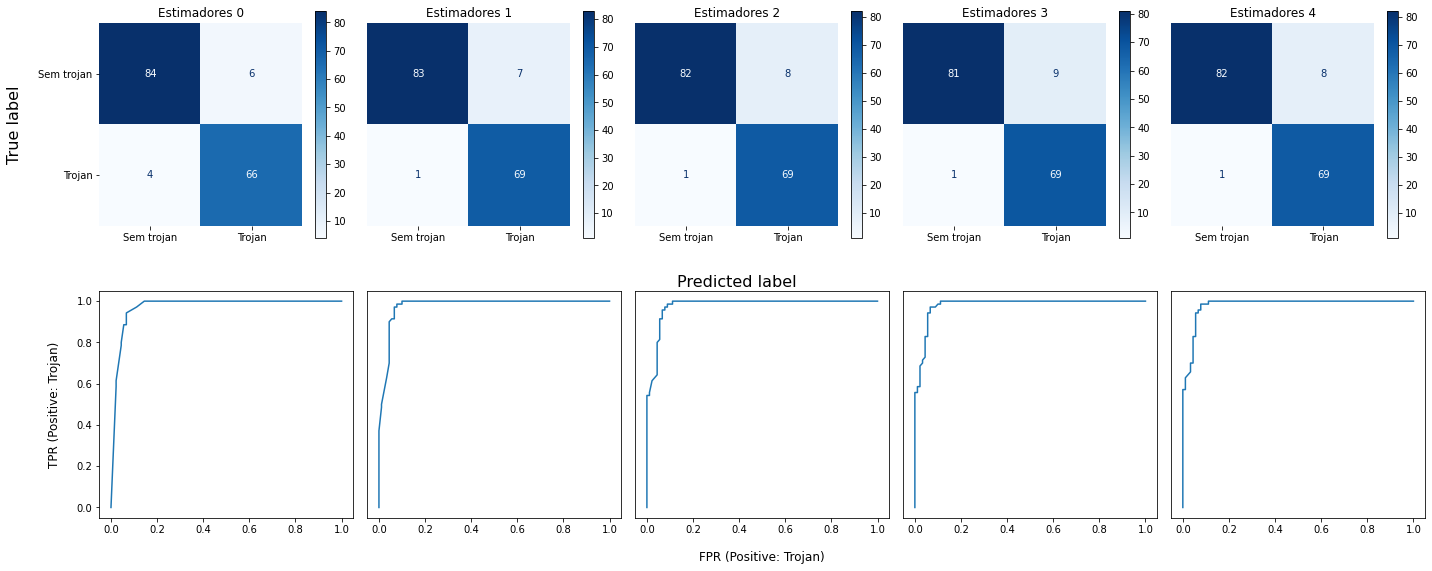

In [ ]:
i = 0
fig, axs = plt.subplots(2, 5, figsize=(20, 8), facecolor='w', edgecolor='k')
clf_precision = {}
clf_acuracy = {}

for n in [10, 50, 100, 500, 1000]:
    # treina modelo 
    clf = RandomForestClassifier(n_estimators=n) # Random forest
    clf.fit(X_train1, Y_train1) # Treina o modelo usando os dados de treinamento
    if n==100:
        clf100 = clf # Salva o modelo de 100 estimadores para teste com a porção 2
    Y_pred = clf.predict(X_test1) # Classifica os dados de teste

    # pega valor de precisão
    clf_precision[str(n)] = metrics.precision_score(Y_test1, Y_pred, average='macro')

    # pega valor de acurácia
    clf_acuracy[str(n)] = metrics.accuracy_score(Y_test1, Y_pred)

    # cria matriz de confusão
    my_plot_confusion_matrix(clf, X_test1, Y_test1, axs, i, 'Estimadores ')
    
    # cria curva roc
    my_plot_roc_curve(clf, X_test1, Y_test1,axs, i)
  
    i += 1

fig.tight_layout()

####Valores de precisão

In [ ]:
my_plot(clf_precision, 'Precision')

####Valores de Acurácia

In [ ]:
my_plot(clf_acuracy, 'Accuracy')

####Valores de Erro

In [ ]:
print('Erros:')

for key, values in clf_acuracy.items():
    print(key + ':', 1-values)

Erros:
10: 0.0625
50: 0.050000000000000044
100: 0.05625000000000002
500: 0.0625
1000: 0.05625000000000002


####Validação Cross

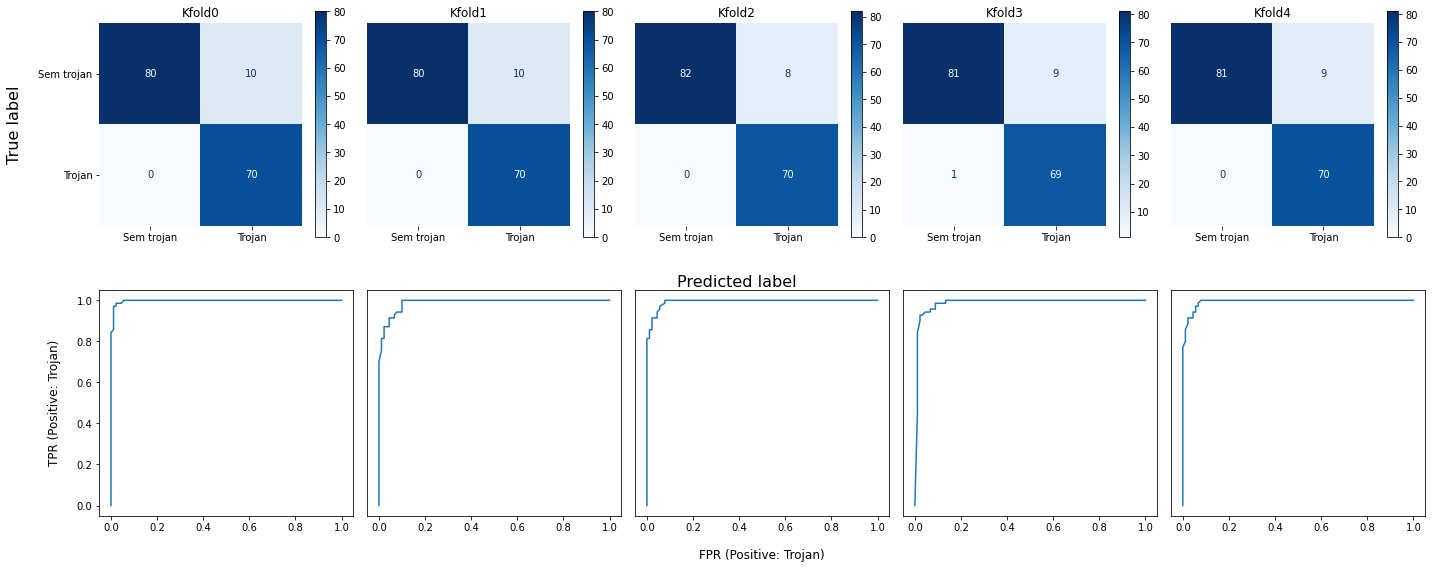

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8), facecolor='w', edgecolor='k')
i = 0
clf_kfold_precision = {}
clf_kfold_acuracy = {}

for train_index, test_index in k_fold.split(part1):
    X_train, Y_train = label_tfidf.iloc[train_index][selected_avs], label_tfidf.iloc[train_index]['target']
    X_test, Y_test = label_tfidf.iloc[test_index][selected_avs], label_tfidf.iloc[test_index]['target']

    clf = RandomForestClassifier(n_estimators=100) # Cria o modelo Random forest
    clf.fit(X_train, Y_train) # Treina o modelo
    Y_pred = clf.predict(X_test) # Classifica os dados de teste

    # pega valor de precisão
    clf_kfold_precision[str(i)] = metrics.precision_score(Y_test1, Y_pred, average='macro')

    # pega valor de acurácia
    clf_kfold_acuracy[str(i)] = metrics.accuracy_score(Y_test1, Y_pred)

    # cria matriz de confusão
    my_plot_confusion_matrix(clf, X_test1, Y_test1,axs, i, 'Kfold')
    
    # cria curva roc
    my_plot_roc_curve(clf, X_test1, Y_test1,axs, i)

    i += 1

fig.tight_layout()

####K-Fold: Valores de precisão

In [ ]:
my_plot(clf_kfold_precision, 'Precision')

####K-Fold: Valores de acurácia

In [ ]:
my_plot(clf_kfold_acuracy, 'Accuracy')

####K-Fold: Valores de Erro

In [ ]:
print('Erros:')

for key, values in clf_kfold_acuracy.items():
    print(key + ':', 1-values)

Erros:
0: 0.55
1: 0.575
2: 0.6
3: 0.575
4: 0.58125


###b. Manipulando a 2° porção

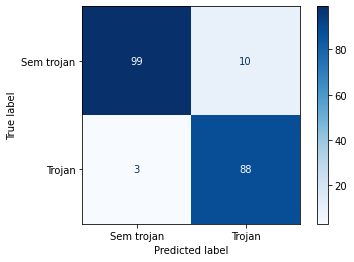

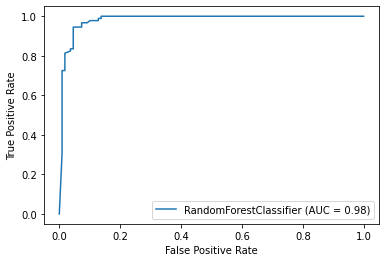

In [ ]:
# cria matriz de confusão
metrics.plot_confusion_matrix(clf100, X_part2, Y_part2, values_format='d', cmap=plt.cm.Blues)    

# cria curva roc
metrics.plot_roc_curve(clf100, X_part2, Y_part2)

In [ ]:
Y_pred_clf = clf100.predict(X_part2)

####Valor de precisão

In [ ]:
clf_part2_precision = metrics.precision_score(Y_part2, Y_pred_clf, average='macro')
print('Precisão: ', clf_part2_precision)

Precisão:  0.9342737094837935


####Valor de acurácia

In [ ]:
clf_part2_accuracy = metrics.accuracy_score(Y_part2, Y_pred_clf)
print('Acurácia: ', clf_part2_accuracy)

Acurácia:  0.935


####Valor de erro

In [ ]:
print('Erro:', 1-clf_part2_accuracy)

Erro: 0.06499999999999995


###c. Discussão

Os erros encontrados na classificaçãão do Random Forest foram na sua grande maioria a classificação erronea de Sem Trojan como Trojan, acreditamos que isso tenha acontecido uma vez que algumas das labels que não foram classificadas como Trojan, possuem o termo trojan em seus rótulos. A escolha de classificação que permitiu esse tipo confusão foi realizado pois caso a regra fosse : se ao menos um antivirus, para aquele mesmo malware o classificasse como trojan então sua label recebia Trojan, caso contrário , Sem Trojan; mais de 90% do dataset estária classificado como Trojan. 
Tirando este detalhe, colocamos o modelo na categoria de classificador com bom desempenho, visto que, o valor da acurácia está acima 0,8.

##3.5 KNN
***

O algoritmo dos **vizinhos mais próximos** baseia-se nos exemplos do conjunto de treinamento que são próximos ao objeto para classificá-lo. Em outras palavras, temos de encontrar **K registros** que tenham características similares ao seu redor, descobrir qual é a classe majoritária entre esses registros semelhantes e atribuir tal classe ao novo registro.

###a. Manipulando 1° porção

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

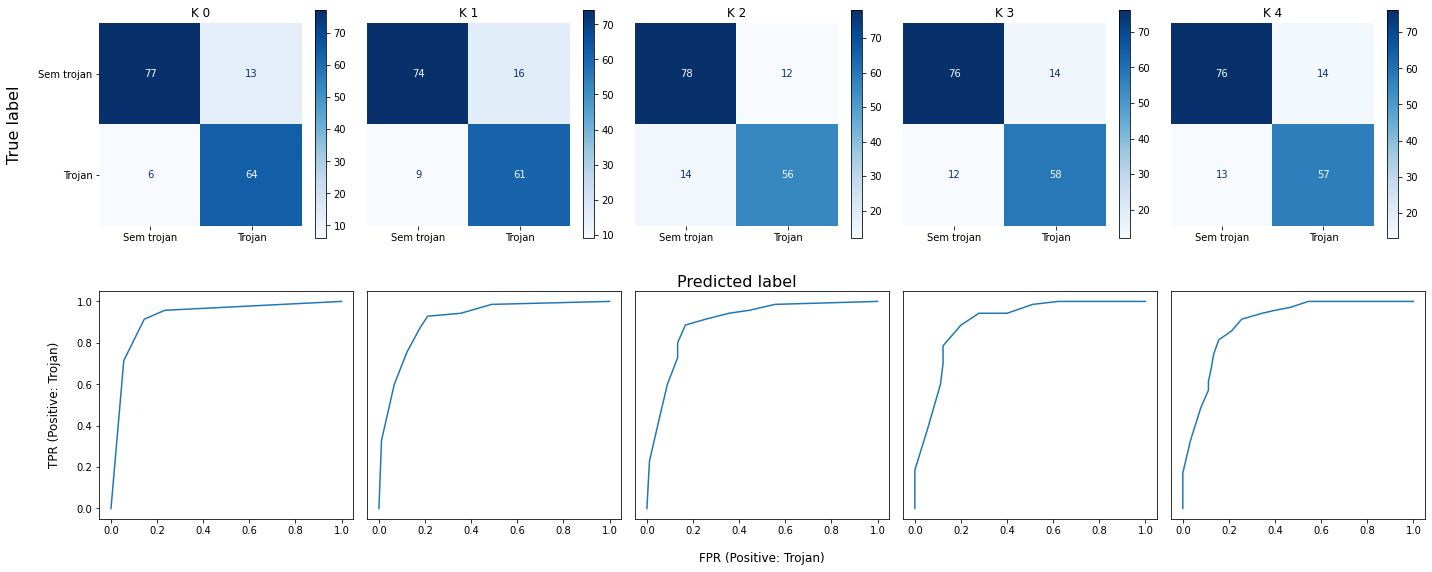

In [ ]:
i = 0
fig, axs = plt.subplots(2, 5, figsize=(20, 8), facecolor='w', edgecolor='k')
knn_precision = {}
knn_acuracy = {}

for n in [3, 7, 10, 13, 16]:
    # treina modelo 
    knn = KNeighborsClassifier(n_neighbors=n) # Random forest
    knn.fit(X_train1, Y_train1) # Treina o modelo usando os dados de treinamento
    if n == 3:
      knn3 = knn
    Y_pred = knn.predict(X_test1) # Classifica os dados de teste

    # pega valor de precisão
    knn_precision[str(n)] = metrics.precision_score(Y_test1, Y_pred, average='macro')

    # pega valor de acurácia
    knn_acuracy[str(n)] = metrics.accuracy_score(Y_test1, Y_pred)

    # cria matriz de confusão
    my_plot_confusion_matrix(knn, X_test1, Y_test1, axs, i, 'K ')
    
    # cria curva roc
    my_plot_roc_curve(knn, X_test1, Y_test1,axs, i)
  
    i += 1

fig.tight_layout()

####Valores de Precisão

In [ ]:
my_plot(knn_precision, 'Precision')

####Valores de acurácia

In [ ]:
my_plot(knn_acuracy, 'Acuracy')

####Valores de Erro

In [ ]:
print('Erros:')

for key, values in knn_acuracy.items():
    print(key + ':', 1-values)

Erros:
3: 0.11875000000000002
7: 0.15625
10: 0.16249999999999998
13: 0.16249999999999998
16: 0.16874999999999996


####Validção Cross

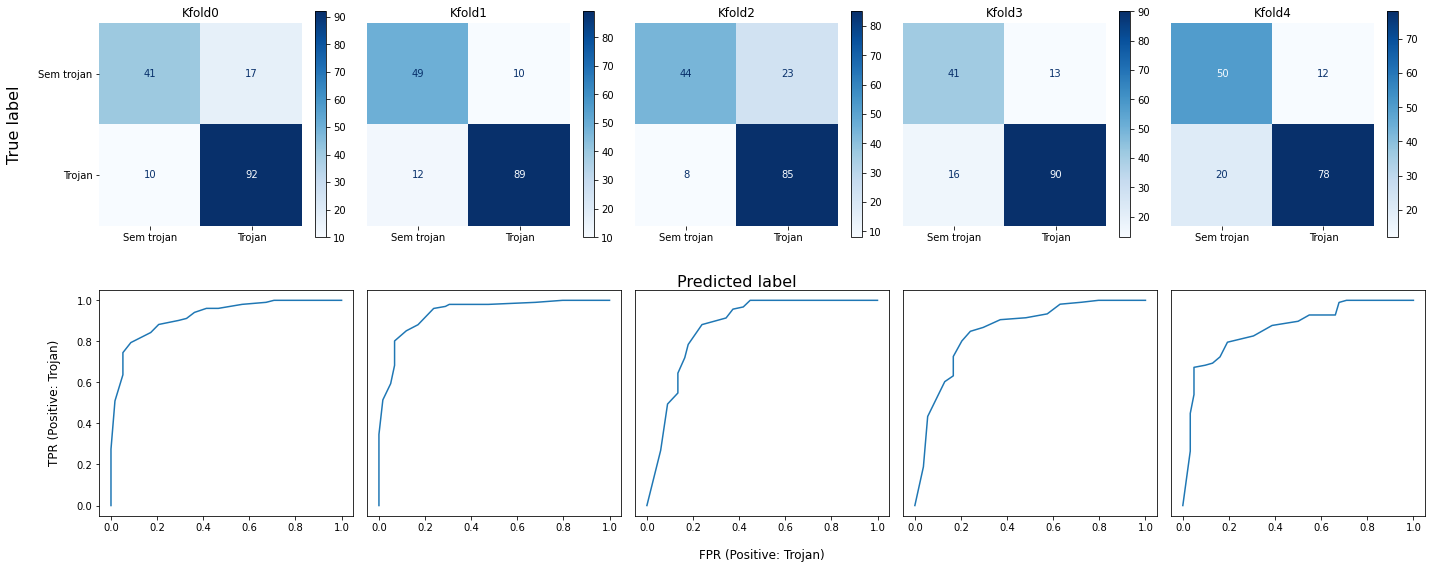

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8), facecolor='w', edgecolor='k')
i = 0
knn_kfold_precision = {}
knn_kfold_acuracy = {}

for train_index, test_index in k_fold.split(part1):
    X_train, Y_train = label_tfidf.iloc[train_index][selected_avs], label_tfidf.iloc[train_index]['target']
    X_test, Y_test = label_tfidf.iloc[test_index][selected_avs], label_tfidf.iloc[test_index]['target']

    knn = KNeighborsClassifier(n_neighbors=n) # Random forest
    knn.fit(X_train, Y_train) # Treina o modelo usando os dados de treinamento
    Y_pred = knn.predict(X_test) # Classifica os dados de teste

    # pega valor de precisão
    knn_kfold_precision[str(i)] = metrics.precision_score(Y_test, Y_pred, average='macro')

    # pega valor de acurácia
    knn_kfold_acuracy[str(i)] = metrics.accuracy_score(Y_test, Y_pred)

    # cria matriz de confusão
    my_plot_confusion_matrix(knn, X_test, Y_test,axs, i, 'Kfold')
    
    # cria curva roc
    my_plot_roc_curve(knn, X_test, Y_test,axs, i)

    i += 1

fig.tight_layout()

####K-Fold: Valores de Precisão

In [ ]:
my_plot(knn_kfold_precision, 'Precisão')

####K-Fold: Valores de Acurácia

In [ ]:
my_plot(knn_kfold_acuracy, 'Acurácia')

####K-Fold: Valores de Erro

In [ ]:
print('Erros:')

for key, values in knn_kfold_acuracy.items():
    print(key + ':', 1-values)

Erros:
0: 0.16874999999999996
1: 0.13749999999999996
2: 0.19374999999999998
3: 0.18125000000000002
4: 0.19999999999999996


###b. Manipulando 2° porção

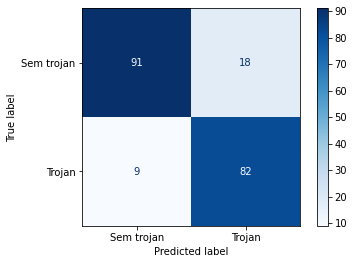

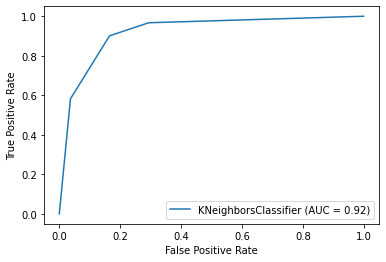

In [ ]:
# cria matriz de confusão
metrics.plot_confusion_matrix(knn3, X_part2, Y_part2, values_format='d', cmap=plt.cm.Blues)    

# cria curva roc
metrics.plot_roc_curve(knn3, X_part2, Y_part2)

In [ ]:
Y_pred_knn3 = knn3.predict(X_part2)

####Valor de Precisão

In [ ]:
knn_part2_precision = metrics.precision_score(Y_part2, Y_pred_knn3, average='macro')
print("Precisão: ", knn_part2_precision )

Precisão:  0.865


####Valores de Acurácia

In [ ]:
knn_part2_accuracy = metrics.accuracy_score(Y_part2, Y_pred_knn3)
print("Acurácia: ", knn_part2_accuracy)

Acurácia:  0.865


####Valor de Erro

In [ ]:
print('Erro:', 1-knn_part2_accuracy)

Erro: 0.135


###c. Discussão


Muitos problemas que podem ser tratados por técnicas AM apresentam um número elevado de atributos. As aplicações de reconhecimento de imagens ganham destaque nessa categoria. Considerando que cada pixel da imagem é um atributo, cada imagem ou instância de uma imagem com 1024 por 1024 pixeis tem mais de um milhão de atributos. E poucas técnicas de Aprendizagem de Máquina podem lidar com um número tão grande.

Chamamos isso de maldição da dimensionalidade. Nela temos que: "Se cada atributo for visto como uma coordenada em um espaço d-dimensional, em que d é o número de atributos, o hiper-volume que representa esse espaço cresce exponencialmente com a adição de novos atributos".

Trazendo o problema para o escopo de métodos baseados em distância, quanto maior a dimensionalidade, provável que haja menor densidade de dados. Isso significa que o tamanho do nosso conjunto de dados também deve crescer exponencialmente para manter a mesma densidade. Se não fizermos isso, os pontos de dados começarão a ficar cada vez mais distantes. 

Contudo, diferente do que se esperava não foi observado uma mudança drástica na acurácia do modelo conforme aumentávamos K. Acredimos que a quantidade de dados tenha sido suficiente para o problema em mãos.

##3.6 Naive Bayes
***

O algoritmo **Naive Bayes** usa a probabilidade de observação de valores preditores, dado um resultado, para estimar a probabilidade de observar o resultado Y = i, dado um conjunto de valores preditores.

Por que esta fórmula é chamada de "naive" ? Fizemos uma suposição simplificada de que a **probabilidade condicional exata** de um vetor dos valores preditores, dada a observação de um resultado, é suficientemente bem estimada pelo produto das probabilidades condicionais individuais P(Xj|Y=i). Em outras palavras, ao estimar P(Xj|Y=i), em vez de P(X1, X2, ...Xp|Y=i), estamos supondo que Xj seja **independente** de todas as outras variáveis preditoras Xk para K!=j.

###a. Manipulando 1° porção

In [ ]:
from sklearn.naive_bayes import GaussianNB

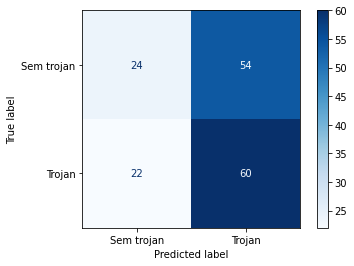

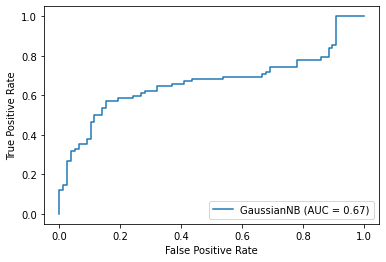

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train1, Y_train1)
Y_pred = gnb.predict(X_test1)

# cria matriz de confusão
metrics.plot_confusion_matrix(gnb, X_test1, Y_test1, values_format='d', cmap=plt.cm.Blues)    

# cria curva roc
metrics.plot_roc_curve(gnb, X_test1, Y_test1)

####Valor de Precisão

In [ ]:
# pega valor de precisão
gnb_precision = metrics.precision_score(Y_test1, Y_pred, average='macro')
print('Precisão: ', gnb_precision)

Precisão:  0.9314736677605875


####Valor de Acurácia

In [ ]:
# pega valor de acurácia
gnb_acuracy = metrics.accuracy_score(Y_test1, Y_pred)
print('Acurácia: ', gnb_acuracy)

Acurácia:  0.45


####Valor de Erro

In [ ]:
print('Erro:', 1-gnb_acuracy)

Erro: 0.55


####Validação Cross

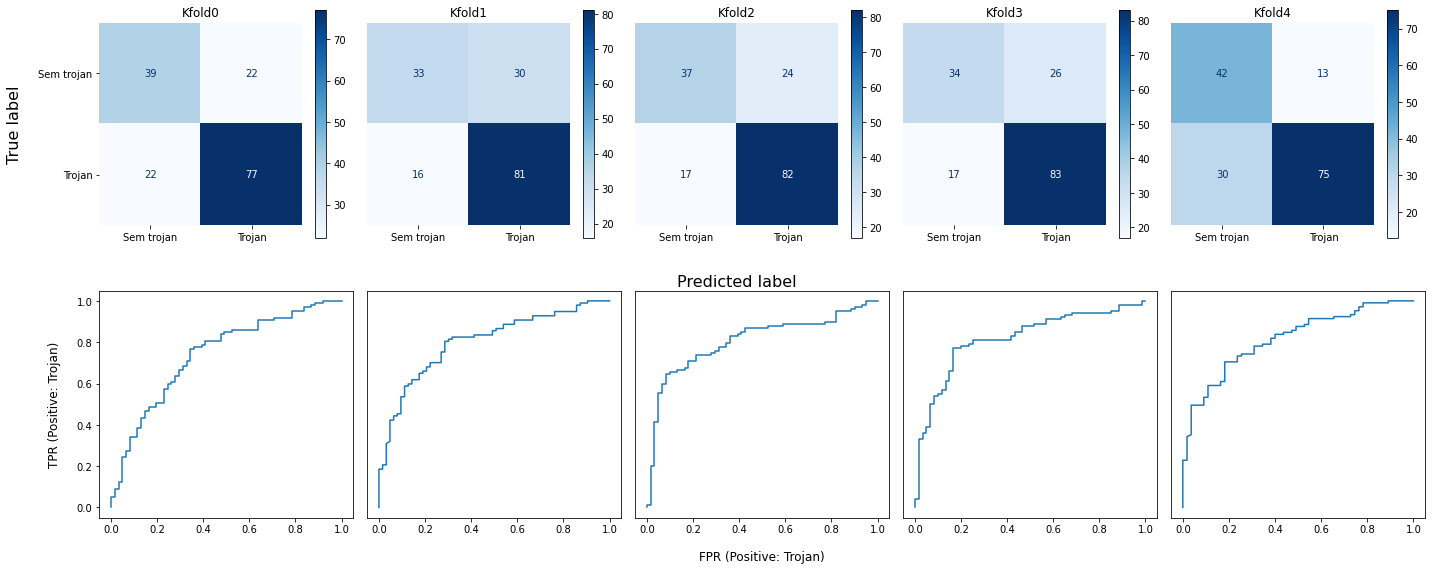

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8), facecolor='w', edgecolor='k')
i = 0
gnb_kfold_precision = {}
gnb_kfold_acuracy = {}

for train_index, test_index in k_fold.split(part1):
    X_train, Y_train = label_tfidf.iloc[train_index][selected_avs], label_tfidf.iloc[train_index]['target']
    X_test, Y_test = label_tfidf.iloc[test_index][selected_avs], label_tfidf.iloc[test_index]['target']

    gnb = GaussianNB()
    gnb.fit(X_train, Y_train)
    Y_pred = gnb.predict(X_test)

    # pega valor de precisão
    gnb_kfold_precision[str(i)] = metrics.precision_score(Y_test, Y_pred, average='macro')

    # pega valor de acurácia
    gnb_kfold_acuracy[str(i)] = metrics.accuracy_score(Y_test, Y_pred)

    # cria matriz de confusão
    my_plot_confusion_matrix(gnb, X_test, Y_test,axs, i, 'Kfold')
    
    # cria curva roc
    my_plot_roc_curve(gnb, X_test, Y_test,axs, i)

    i += 1

fig.tight_layout()

####K-Fold: Valores de Precisão

In [ ]:
my_plot(gnb_kfold_precision, 'Precisão')

####K-Fold: Valores de Acurácia

In [ ]:
my_plot(gnb_kfold_acuracy, 'Acurácia')

####K-Fold: Valores de Erro

In [ ]:
print('Erros:')

for key, values in gnb_kfold_acuracy.items():
    print(key + ':', 1-values)

Erros:
0: 0.275
1: 0.2875
2: 0.25625
3: 0.26875000000000004
4: 0.26875000000000004


###b. Manipulando 2° porção

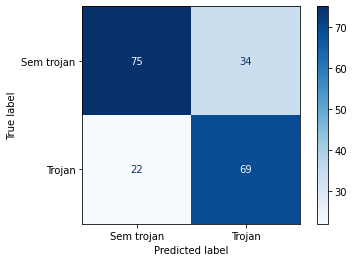

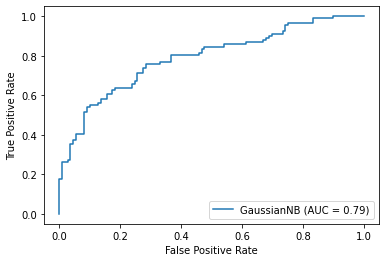

In [ ]:
# cria matriz de confusão
metrics.plot_confusion_matrix(gnb, X_part2, Y_part2, values_format='d', cmap=plt.cm.Blues)    

# cria curva roc
metrics.plot_roc_curve(gnb, X_part2, Y_part2)

In [ ]:
Y_pred_gnb = gnb.predict(X_part2)

####Valor de Precisão

In [ ]:
gnb_part2_precision = metrics.precision_score(Y_part2, Y_pred_gnb, average='macro')
print("Precisão: ", gnb_part2_precision )

Precisão:  0.7215493944550095


####Valor de Acurácia

In [ ]:
gnb_part2_accuracy = metrics.accuracy_score(Y_part2, Y_pred_gnb)
print("Acurácia: ", gnb_part2_accuracy)

Acurácia:  0.72


####Valor de Erro

In [ ]:
print('Erro:', 1-knn_part2_accuracy)

Erro: 0.135


###c. Discussão

Como o algoritmo assume independência das características, se a correlação entre os fatores forem extremamente importantes, o Naive Bayes pode falhar na predição da nova informação. O que pode ser observado no valor baixo de acurácia conseguido pelo modelo, uma vez que, a regra de rotulação do dataset se baseia na dependência de valores entre os rótulos, a mudança de categorização de um, pode modificar a classificação do exemplar de análise. 

# 4 Conclusão
***

Em conclusão, percebemos que a extração de características é um passo de extrema importância. Visto que os erros de classificação observados se deram pela escolha de regra classificação dos exemplares do dataset de análise. Contudo acrescentamos que, embora a escolha de construção do dataset poderia ter sido melhor, tivemos resultados satisfatórios para o objetivo proposto com os modelos KNN e RandomForest.